# Lab 10 - Exploring vs. exploiting

This lab will exlore how the win-stay, lose-switch (WSLS) approach to the exploration-exploitation dilemma boosts curious exploration in our little bacteria friends.

Sections:
1. Curiosity and reward seeking as a dualing search strategy
2. Comparing all the methods we have learned so far




## Background
In this final lab we take on all the agents that we have studied so far and some new ones too.


_The decisions to be made this week are the exact opposite of every other lab_.

I am giving you six tuned agents, and three "levers" which control the environment. The now familiar scent grid. Your job this week is to see how curiosity and reward learning bias our search.

Our target metrics:
- It must gather the most total reward, by a clear margin (error baar overlap)
- It must not die the most. That is, as long as one other agent dies more often, or all agents die 0 times, we'll call that good enough. (Any experimental trial which does not lead to finding at least a single target (aka reward) means the exploring agent dies. It's a harsh noisy world we live in, after all.)

Once again, on final time it's time for _taxic explorations_. We revisit the sniff world (aka _ScentGrid_) with a familiar twist. We look again at what happens when sense information is not just noisy, but suddenly missing altogether. A concrete, cheap to simulate, case of this is turbulent flows.


### Our agents, this time
We will study six agents. They are,

- Rando (aka rando-taxis) (aka _DiffusionGrid_)
- Chemo (aka chemo-taxis) (aka _GradientDiffusionGrid_)
- Accumulator (aka "smart" chemo-taxis) (aka _AccumulatorGradientGrid_)
- Info (aka "smart" info-taxis) (aka _AccumulatorInfoGrid_)
- RL w/ random softmax search (aka _ActorCriticGrid_)
- Curiosity and RL union (aka rewardo- and info-taxis) (aka _WSLSGrid_)

The goal is to _the change the world_ -- until each agent "wins" (defined above).

### Our agents, in review

**Rando** (rando-taxis): Actions are sampled from an exponential distribution. For the _randotaxis_ agent number of steps means the number of steps or actions the agent takes.

**Chemo** (chemo-taxis): Recall our basic model of E. Coli exploration is as simple as can be.

- When the gradient is positive, meaning you are going "up" the gradient, the probability of turning is set to _p pos_.
- When the gradient is negative, the turning probability is set to _p neg_. (See code below, for an example).
- If the agent "decides" to turn, the direction it takes is uniform random.
- The length of travel before the next turn decision is sampled from an exponential distribution just like the _DiffusionGrid_

**Accumulator** ("smart", chemo- and info-taxis): Both _chemo-_ and _infotaxis_ agents will use a DDM-style accumulator to try and make better decisions about the direction of the gradient. These decisions are of course statistical in nature. (We won't be tuning the accumulator parameters in this lab. Assume the parameters I give you, for the DDM, are "good enough".)

As before we will assume that the steps are in a sense conserved. For the other two (accumulator) agents a step can mean two things. For accumulator agents a step can be spent sampling/weighing noisy scent evidence in the same location, or it can be spent moving to a new location. _Note_: Even though the info-accumulator is more complex, it can take advantage of missing scent information to drive its behavior. It can also use positive scent hits, of course, too.

**Info** (info-taxis): A simple change detection agent that builds a map of the world and keeps track of what information each position contains by looking for a change in its internal memory.

**RL** (rewardo-taxis): A Q-learning agent with softmax exploration. The RL agent has no shaping function, or intrinsic reward. It does not use the scent, in other words. It learns to value each position on the grid and make its immediate choices based on the value of the four possible actions that it can make (up, down, left, right).

**WSLS** (reward- and info-taxis): A agent that alternates between info-taxis and Q-learning. Both are deterministic. Exploration and exploitation without any random search, in other words.

_Details_: For this model a memory $M$ is a discrete probability distribution. I define information value $E$ on the norm of the derivative ($\nabla M), approximated by $\hat E = || f(x, M) - M ||$, where $||.||$ denotes the norm. (Norms are distances like hypotanooses.)

The goal of any info-taxis (aka, curiosity agent) is to maximize $E$, I claim, based on a Bellman-optimal policy $\pi^*_E$.

So armed with $\hat E$ I write down another (meta) policy $\pi^{\pi}$, in terms of a mixed series of values, $\hat E$ and environmental rewards $R$. This WSLS rule is shown below. The reward (exploit) policy $\pi_R$ is Q learning, same as for **RL**.

$$
    \begin{split}
        \Pi_{\pi} =
        \begin{cases}
            \pi^*_{\hat{E}} & : \hat{E} - \eta > R + \rho \\
            \pi_R 	& : \hat{E} - \eta < R + \rho \\
        \end{cases}
    \end{split}
$$



## Section 0 - Setup


### Install and import needed modules

In [ ]:
# Install explorationlib?
!pip install --upgrade git+https://github.com/parenthetical-e/explorationlib
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git

  Cloning https://github.com/parenthetical-e/explorationlib to /tmp/pip-req-build-r5006bph
  Running command git clone --filter=blob:none --quiet https://github.com/parenthetical-e/explorationlib /tmp/pip-req-build-r5006bph
  Resolved https://github.com/parenthetical-e/explorationlib to commit 6ed899dafd40d0c87bf5fd1d44e0af610b8eab75
  Preparing metadata (setup.py) ... done
  Created wheel for explorationlib: filename=explorationlib-0.0.1-py3-none-any.whl size=42775 sha256=ed3ce4b18e9a8a78dba07f269715d7b2662f0e1788d9617f4a7f50a6875b1ae4
  Stored in directory: /tmp/pip-ephem-wheel-cache-x2blpt53/wheels/d9/d4/9d/27de3c1116f2d61555f595f2d2f5e4bad227a58ce9999d2438
Successfully built explorationlib
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-5wup1yaq
  Running command git clone --filter=blob:none --quiet https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-5wup1yaq
  Resolved https://github.com/MattChanTK/gym-maze.git to commit 83176811b49b5538a621352

In [ ]:
import shutil
import glob
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

import explorationlib
from explorationlib.local_gym import ScentGrid

from explorationlib.agent import WSLSGrid
from explorationlib.agent import CriticGrid
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import GradientInfoGrid
from explorationlib.agent import ActorCriticGrid

from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import constant_values
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import add_noise
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_patch_targets


from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid
from explorationlib.plot import plot_targets2d

from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

/usr/local/lib/python3.10/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

### Environment


In [ ]:
# Noise and delete
p_scent = 0.1
noise_sigma = 2.0

# Shared
num_experiments = 100
num_steps = 200
seed_value = 5838
num_targets = 20

# Environment parameters
n_patches = 8 #         # number of patches
n_per_patch = 20 #      # number targets per patch
radius = 1 #            # radius of each patch
target_boundary = (10, 10)


# ! (leave alone)
detection_radius = 1
cog_mult = 1
max_steps = 1
min_length = 1

# Targets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

## Section 1 -  WSLS as a search strategy

### WSLS

Let's include our curious agent in with the RL (_rewardtaxis_) agent and have them essetnially work together. Remember, this agent tracks the value of information as well as the value of rewards. It is basically two agents acting as one: the RL agent and an info-taxis agent.

The WSLS agnet makes a choice to go after whatever action has the highest value ($R$ or $E$), swtiching back and forth between seeking rewards (i.e., targets) and information.

In [ ]:
# Shared parameters
seed_value = 52317
min_length = 1

# WSLS
possible_actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
num_action = len(possible_actions)
initial_bins = np.linspace(0, 1, 10)

critic_R = CriticGrid(default_value=0.0)
critic_E = CriticGrid(default_value=np.log(num_action))
actor_R = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)
actor_E = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)

wsls = WSLSGrid(
    actor_E,
    critic_E,
    actor_R,
    critic_R,
    initial_bins,
    lr=0.1,
    gamma=0.1,
    boredom=0.0
)

# Rando
diff = DiffusionGrid(min_length=min_length)
diff.seed(seed_value)

# !
wsls_exp = experiment(
    f"wsls",
    wsls,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

wsls:   0%|          | 0/100 [00:00<?, ?it/s]

rand:   0%|          | 0/100 [00:00<?, ?it/s]

Just like before, let's look at our random agent's behavior for later comparisons.

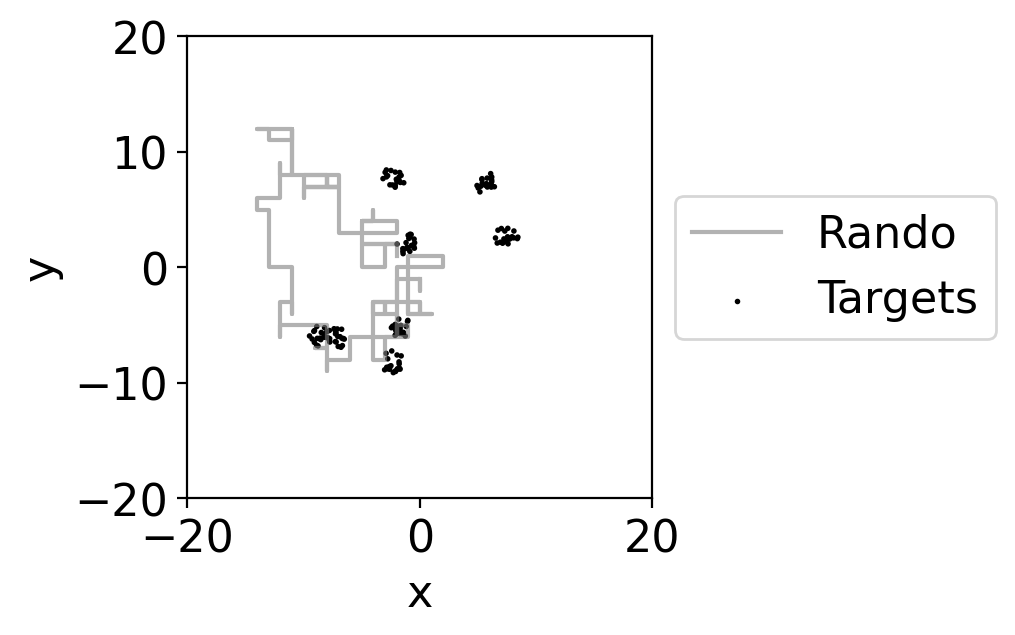

In [ ]:
plot_boundary = (20, 20)

# -
num_experiment = 99
ax = None
ax = plot_position2d(
    select_exp(rand_exp, num_experiment),
    boundary=plot_boundary,
    label=f"Rando",
    color="grey",
    alpha=0.6,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

**Reward AND Information value across learning**

Just like before, let's see how the behavior of our WSLS agent changes across repeated exposures to the same environment.

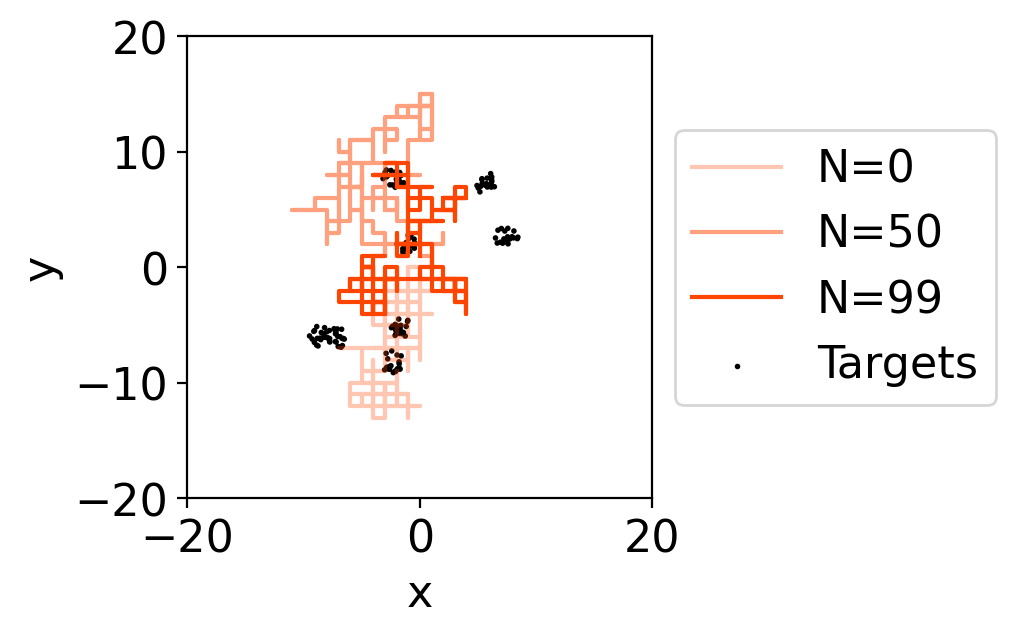

In [ ]:
plot_boundary = (20, 20)

# -
num_experiment = 0
ax = None
ax = plot_position2d(
    select_exp(wsls_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orangered",
    alpha=0.3,
    ax=ax,
)
num_experiment = 50
ax = plot_position2d(
    select_exp(wsls_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orangered",
    alpha=0.5,
    ax=ax,
)
num_experiment = 99
ax = plot_position2d(
    select_exp(wsls_exp, num_experiment),
    boundary=plot_boundary,
    label=f"N={num_experiment}",
    color="orangered",
    alpha=1,
    ax=ax,
)
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

---
### Question 1.1

Based off of the behavior of our WSLS agent, how well do you think it will perform after repeated runs (compared to the Rando agent)?

__Answer:__

It will do better than the rando agent over time.

**Value over time**

Again let's look at the optional Value driving the action ($R$ or $E$) of our agent.


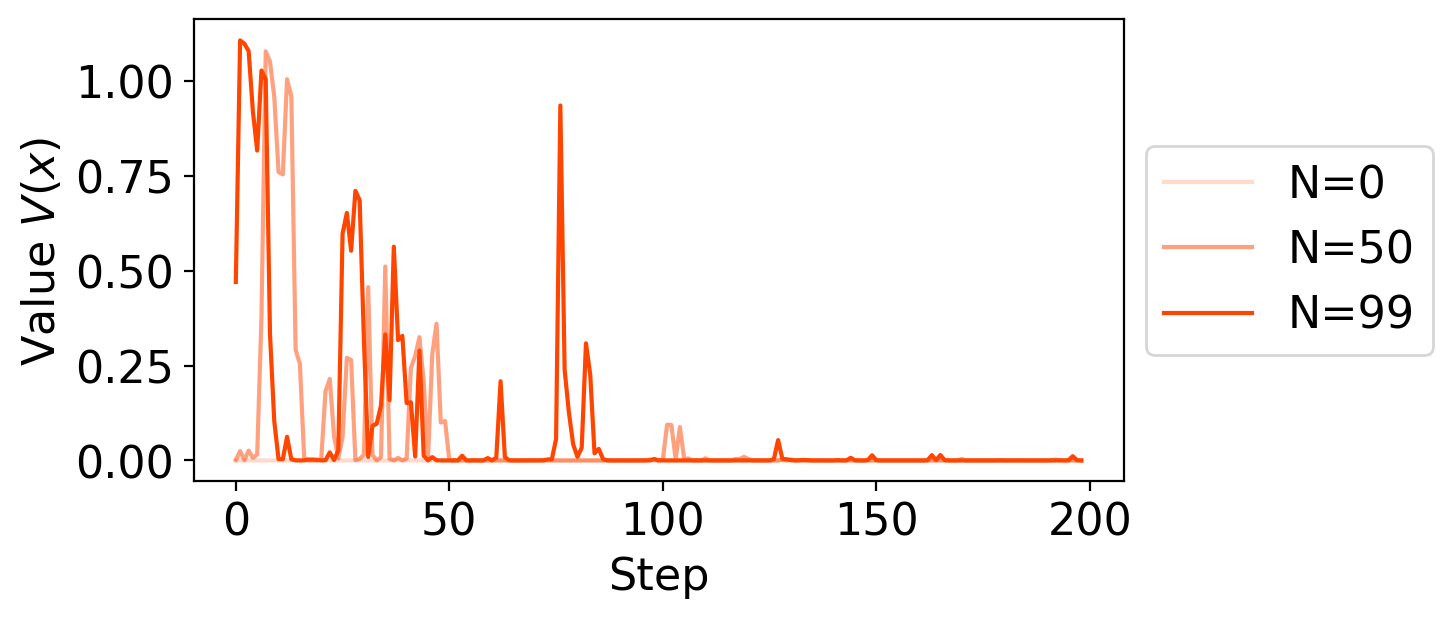

In [ ]:
fig = plt.figure(figsize=(6, 3))
plt.plot(wsls_exp[0]["agent_reward_value"], label="N=0", color="orangered", alpha=0.2)
plt.plot(wsls_exp[50]["agent_reward_value"], label="N=50", color="orangered", alpha=0.5)
plt.plot(wsls_exp[99]["agent_reward_value"], label="N=99", color="orangered", alpha=1)
plt.ylabel("Value $V(x)$")
plt.xlabel("Step")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

**Deaths**

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

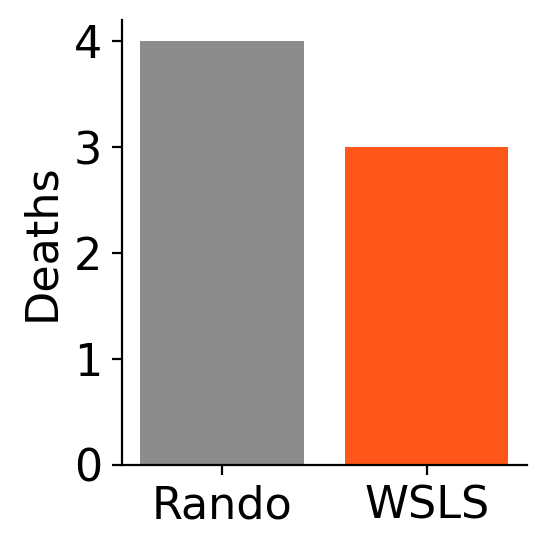

In [ ]:
# Results
results = [rand_exp, wsls_exp]
names = ["Rando", "WSLS"]
colors = ["grey", "orangered"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.9)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

**Total reward**

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

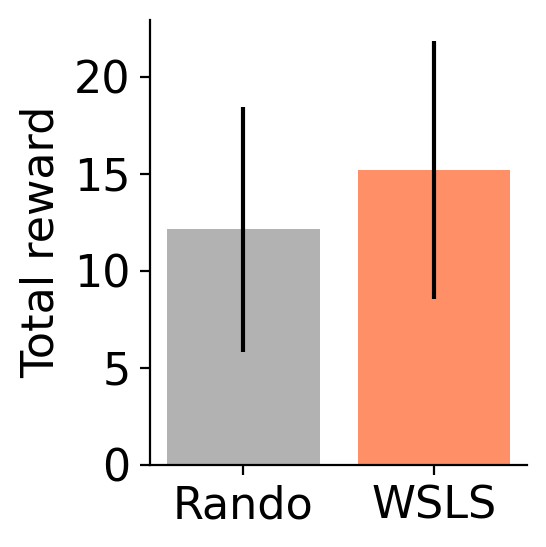

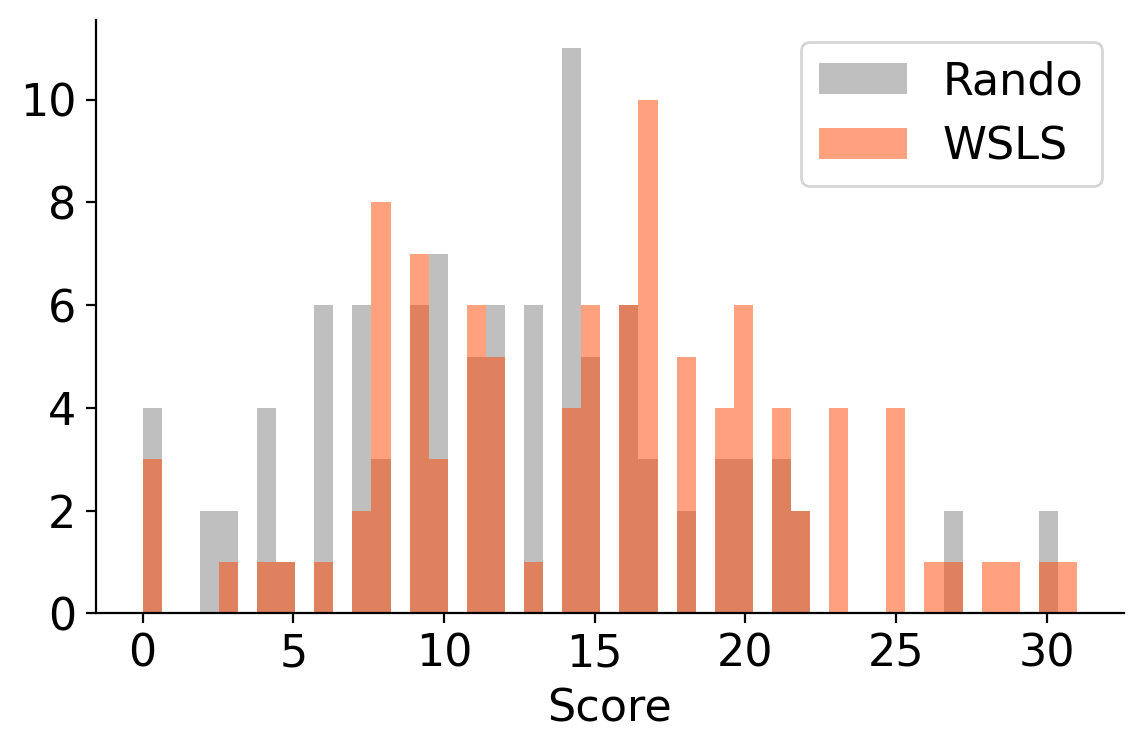

In [ ]:
# Results
results = [rand_exp, wsls_exp]
names = ["Rando", "WSLS"]
colors = ["grey", "orangered"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(6, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 1.2

Based on the performance you have seen above, is it better to be curious and greedy, or greedy and noisy?
Compare the RL agent to the WSLS agent (and Rando for control).

__Answer:__

The WSLS agent performs better than the RL agent so it is better to be greedy and noisy.

---
### Question 1.3
The WSLS approach should have generated more total reward. It may also have had a few (< 10) deaths. (If it did not, try running the WSLS cells again).

Likewise, if you study WSLS search behavior and value learning time courses, you'll see it "settles down" to one rewarding spot and can stay there.

In other words, WSLS is a method with very high inductive bias.

Based on the results in this lab so far, and lecture on managing the exploration-exploitation dilemma, how could you change the env so that the exploration bias behind WSLS (deterministic learning maximization) fails, but the random search of RL does not.

_Note:_ It is helpful to consider the total reward distribution plots carefully. The middle and the bottom range, especially. (Try rerunning?)

_Note_: Everything is on the table. Your counter-example can be whatever you want, well as long as it is physically possible. Be imaginative!

__Answer:__

In a completely unpredictable changing environment - Rando will do better but in a really sparse environment - WSLS will do better.

## Section 2 - The battle royale of our bacteria agents

Now let's run all of our agents on the same world from Sections 1 and 2.

**Keep our environment the same**

Just resetting here in case we tweaked parameters above.

In [ ]:
# Noise and delete
p_scent = 0.1
noise_sigma = 2.0

# Shared
num_experiments = 100
num_steps = 200
seed_value = 5838
num_targets = 20

# Environment parameters
n_patches = 8 #         # number of patches
n_per_patch = 20 #      # number targets per patch
radius = 1 #            # radius of each patch
target_boundary = (10, 10)


# ! (leave alone)
detection_radius = 1
cog_mult = 1
max_steps = 1
min_length = 1

# Targets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)
values = constant_values(targets, 1)

# Scents
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Env
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

**Run 'em all!**

Now we can run all 6 of our agent types in the environment, the same way, and see how well they did.

In [ ]:
# Agents

# rando
rando = DiffusionGrid(min_length=min_length)
rando.seed(seed_value)

# chemo
chemo = GradientDiffusionGrid(
    min_length=min_length,
    p_neg=1,
    p_pos=0.0
)
chemo.seed(seed_value)

# accum
accum = AccumulatorGradientGrid(
    min_length=min_length,
    max_steps=max_steps,
    drift_rate=3,
    threshold=2,
    accumulate_sigma=1
)
accum.seed(seed_value)

# info
info = GradientInfoGrid(
    min_length=min_length,
    p_neg=1,
    p_pos=0.0,
    threshold=0.05
)
info.seed(seed_value)

# RL
critic = CriticGrid(default_value=0.5)
actor = SoftmaxActor(num_actions=4, actions=possible_actions, beta=4)
rl = ActorCriticGrid(actor, critic, lr=0.1, gamma=0.1)

# WSLS
possible_actions = [(0, 1), (0, -1), (1, 0), (-1, 0)]
num_action = len(possible_actions)
initial_bins = np.linspace(0, 1, 10)

critic_R = CriticGrid(default_value=0.5)
critic_E = CriticGrid(default_value=np.log(num_action))
actor_R = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)
actor_E = SoftmaxActor(num_actions=4, actions=possible_actions, beta=20)

wsls = WSLSGrid(
    actor_E,
    critic_E,
    actor_R,
    critic_R,
    initial_bins,
    lr=0.1,
    gamma=0.1,
    boredom=0.0
)

# !
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

accum_exp = experiment(
    f"accum",
    accum,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps * cog_mult,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
rl_exp = experiment(
    f"rl",
    rl,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

wsls_exp = experiment(
    f"wsls",
    wsls,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/100 [00:00<?, ?it/s]

chemo:   0%|          | 0/100 [00:00<?, ?it/s]

accum:   0%|          | 0/100 [00:00<?, ?it/s]

info:   0%|          | 0/100 [00:00<?, ?it/s]

rl:   0%|          | 0/100 [00:00<?, ?it/s]

wsls:   0%|          | 0/100 [00:00<?, ?it/s]

**Search behavior**

Let's just take a look at the movements of each agent at the last run of the repeated tests.

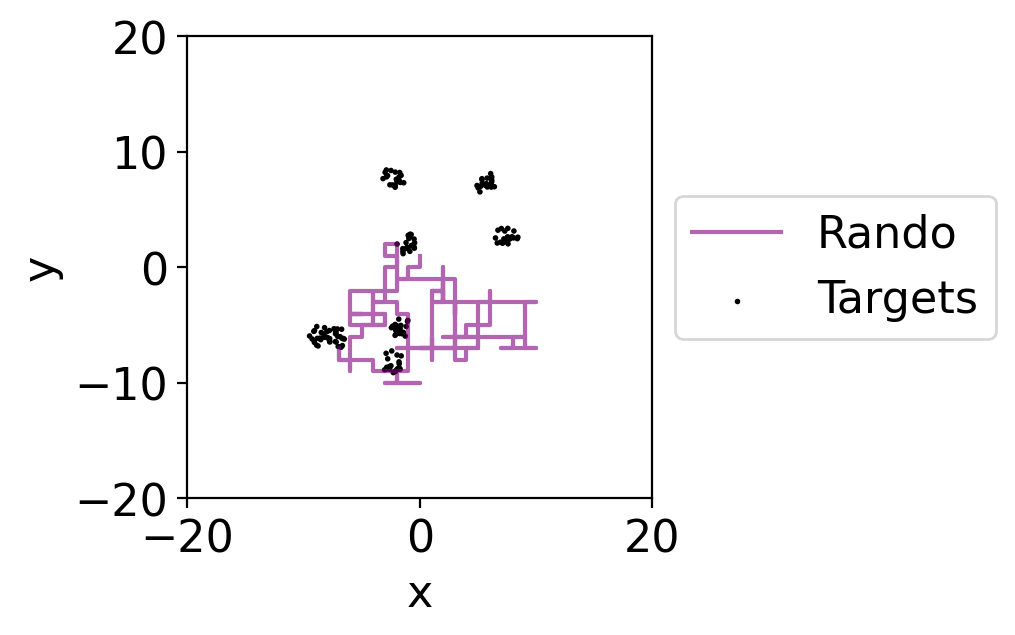

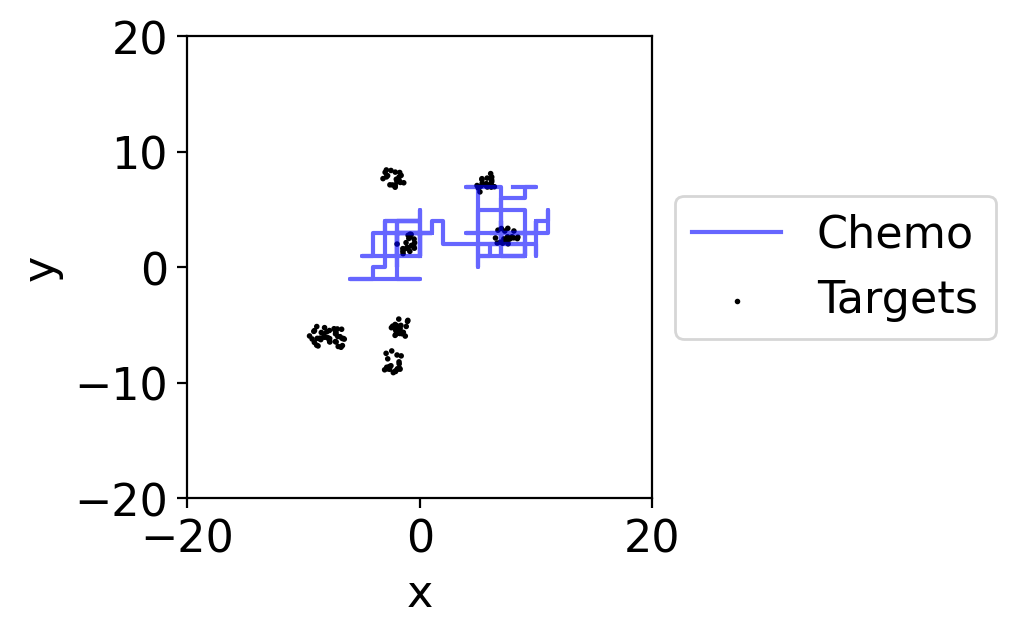

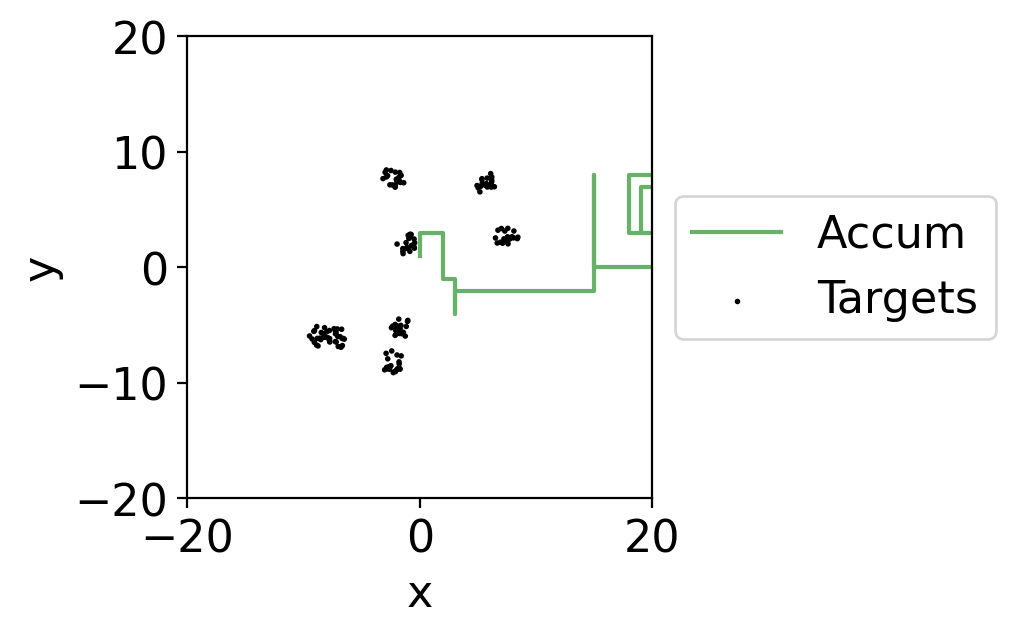

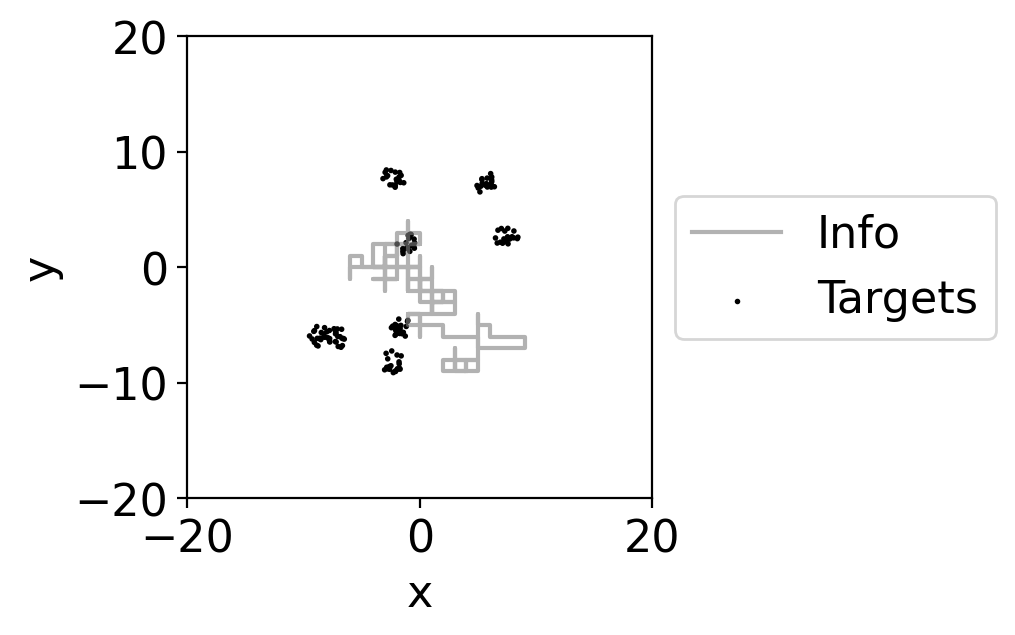

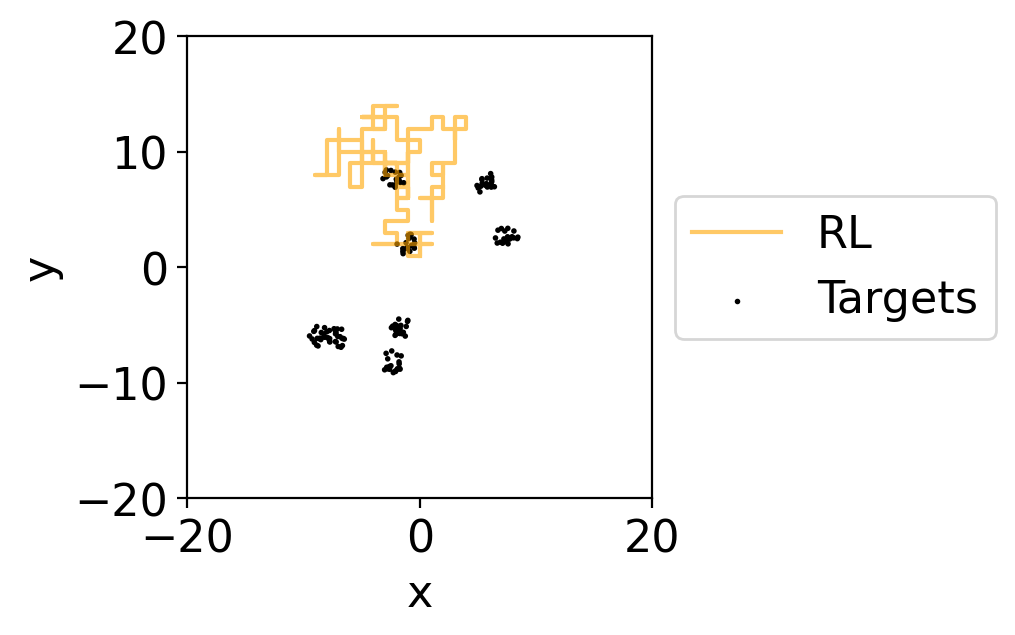

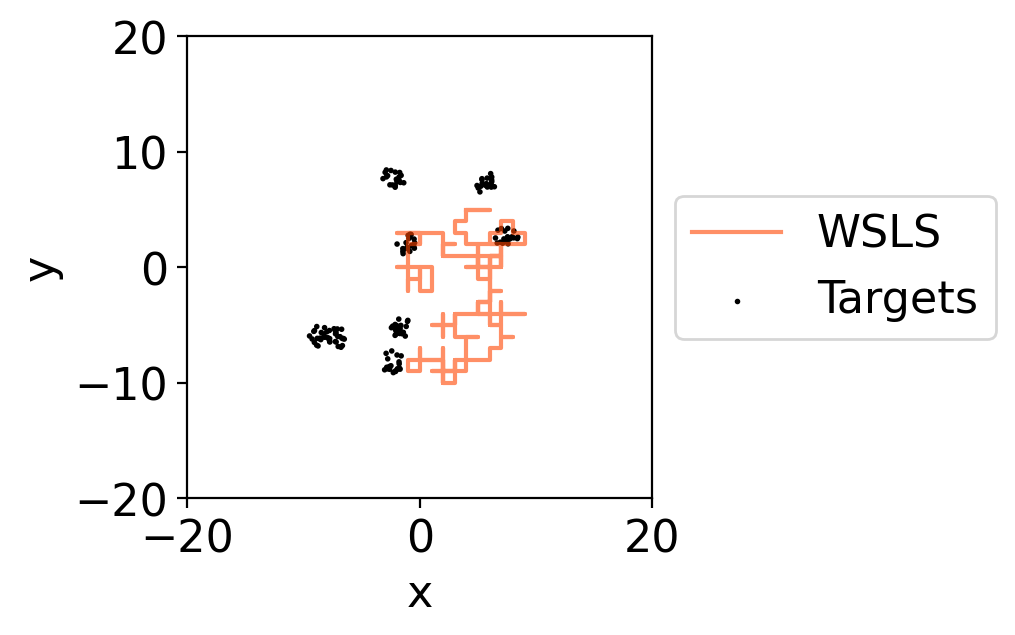

In [ ]:
plot_boundary = (20, 20)
num_experiment = 99

# Results
results = [rand_exp, chemo_exp, accum_exp, info_exp,  rl_exp, wsls_exp]
names = ["Rando", "Chemo", "Accum", "Info", "RL", "WSLS"]
colors = ["purple", "blue", "green", "grey", "orange", "orangered"]

for name, res, color in zip(names, results, colors):
    ax = None
    ax = plot_position2d(
        select_exp(res, num_experiment),
        boundary=plot_boundary,
        label=f"{name}",
        color=color,
        alpha=0.6,
        ax=ax,
    )
    ax = plot_targets2d(
        env,
        boundary=plot_boundary,
        color="black",
        alpha=1,
        label="Targets",
        ax=ax,
    )

---
### Question 2.1

What do you see in the different agents' behavior? Who moved more and who moved less?

__Answer:__

The WSLS and rando agent moved the most and seemed to get the highest reward as they hit the most patches. The RL and Chemo agent had similar distances traveled and similar patches hit. The accumulator agent traveled the least and hit no patches.

**Now let's run one final evaluation to test them all**

**Death**

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

num_death:   0%|          | 0/100 [00:00<?, ?it/s]

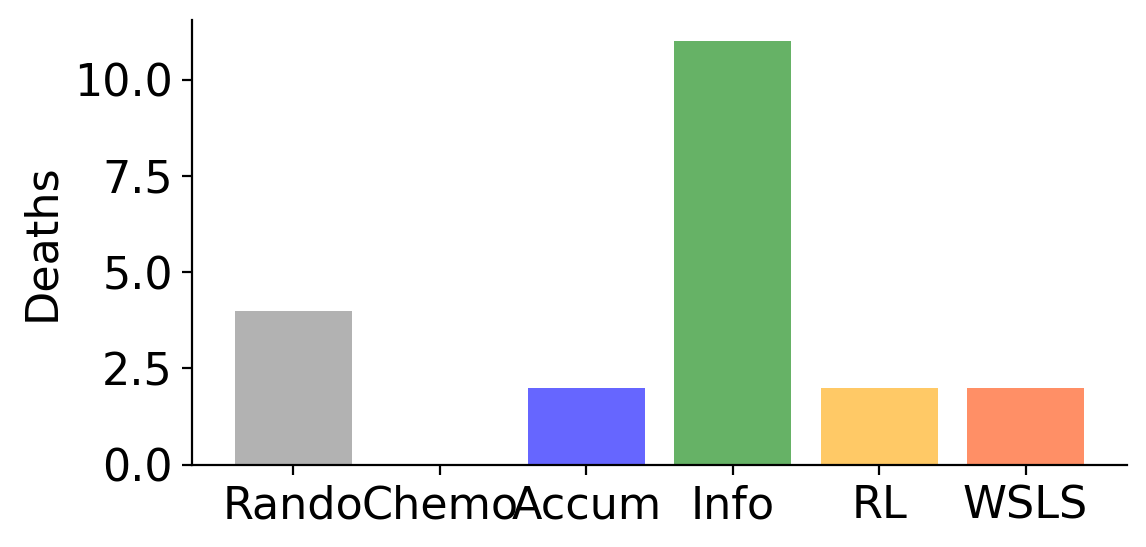

In [ ]:
# Results
colors = ["grey", "purple", "blue", "green", "orange", "orangered"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

**Time on Patch**


on_off_patch_time:   0%|          | 0/100 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/100 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/100 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/100 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/100 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/100 [00:00<?, ?it/s]

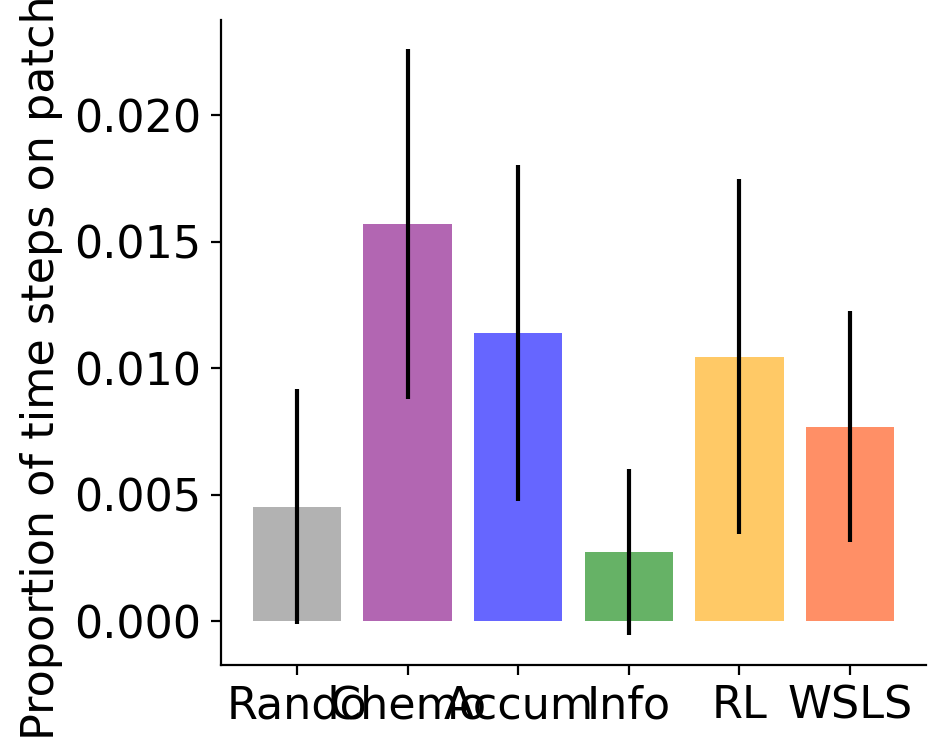

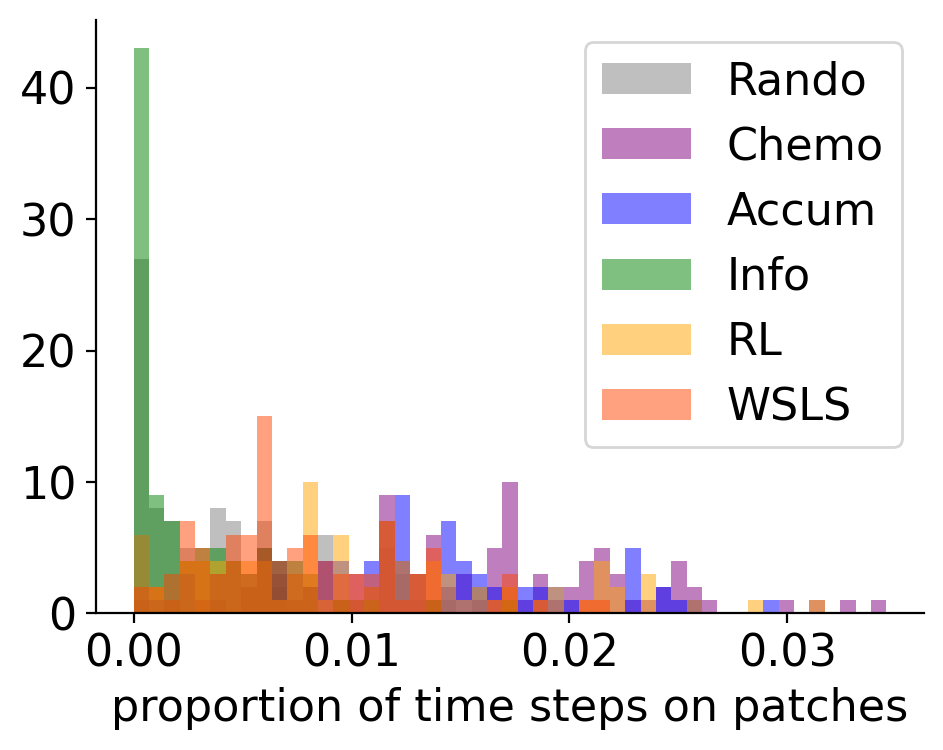

In [ ]:
# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

**Total reward**

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

total_reward:   0%|          | 0/100 [00:00<?, ?it/s]

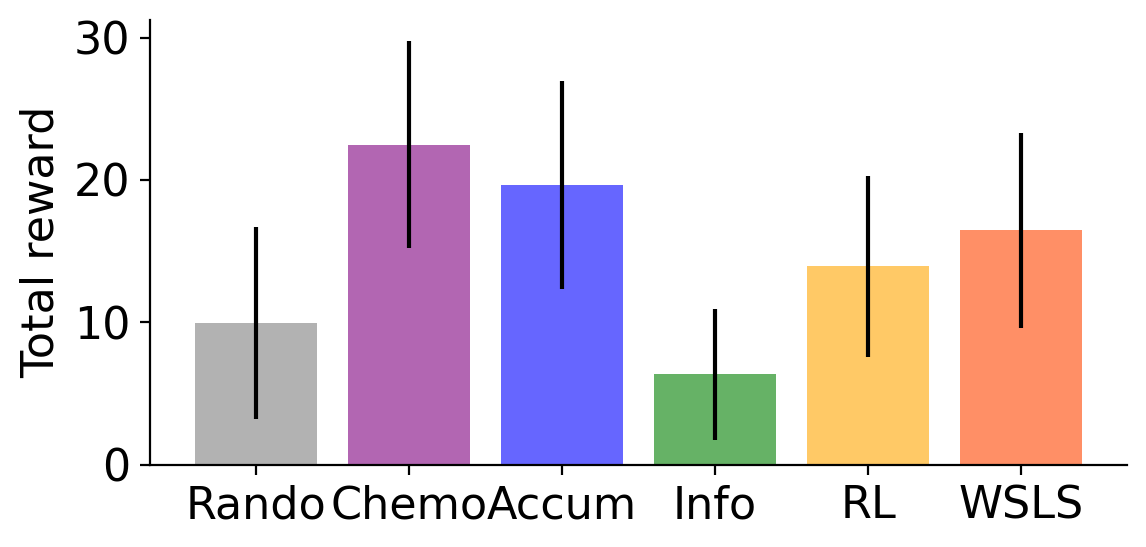

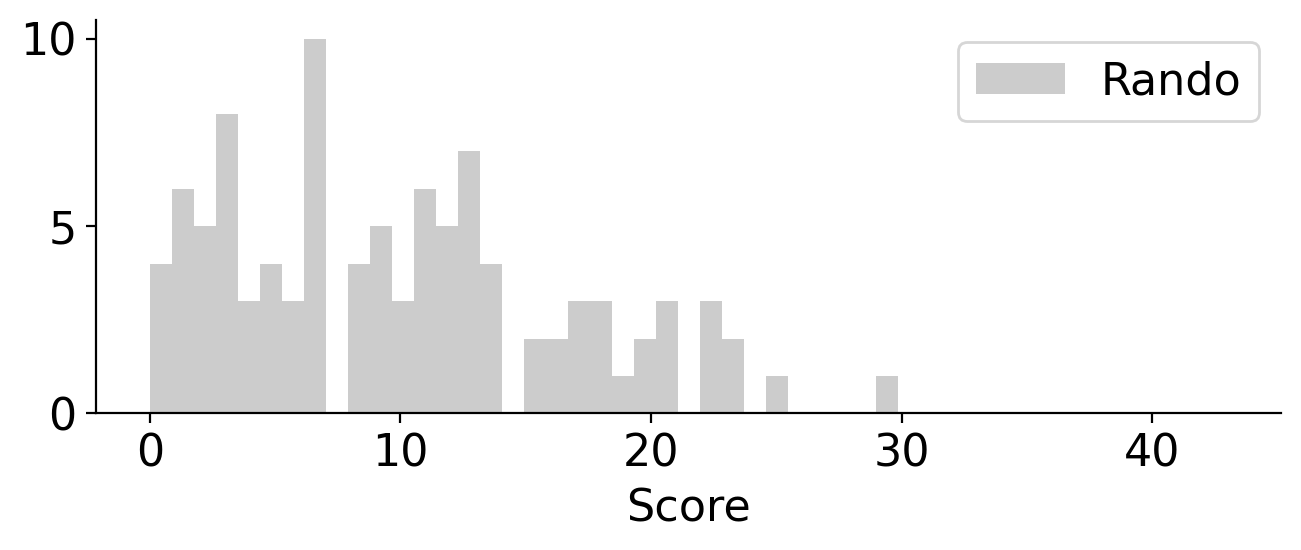

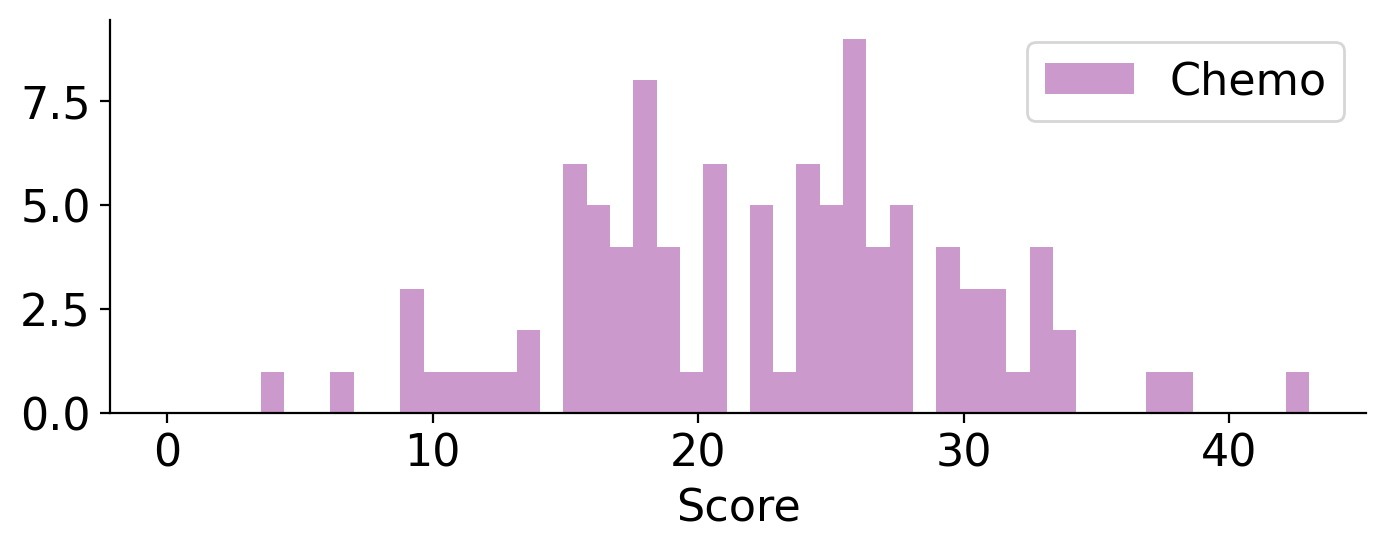

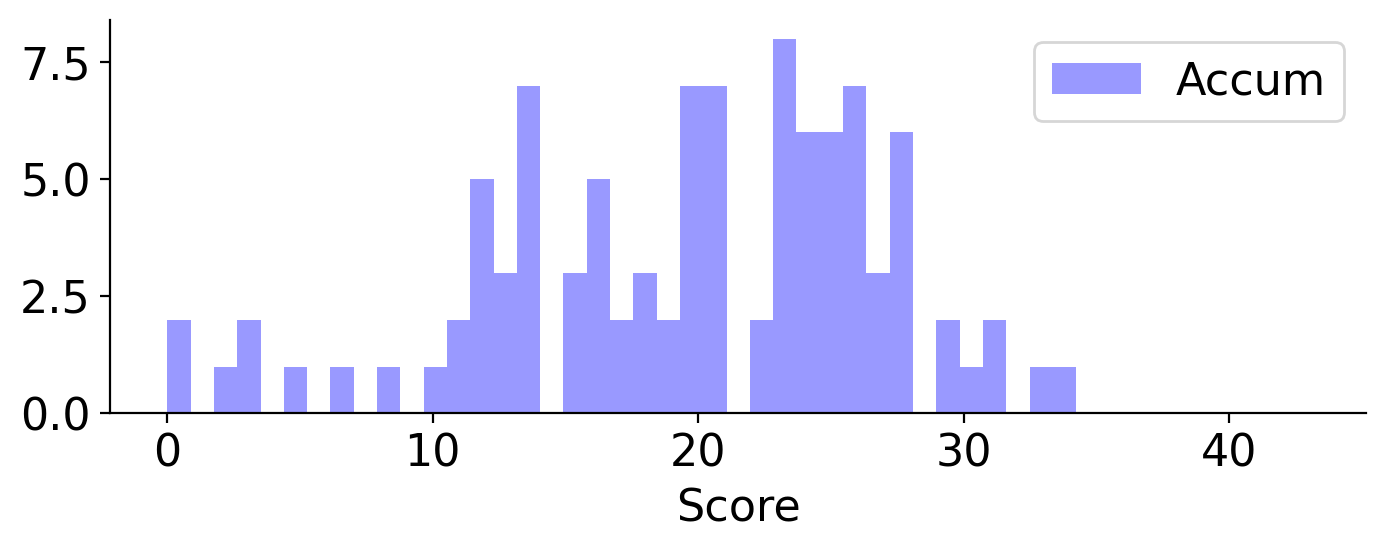

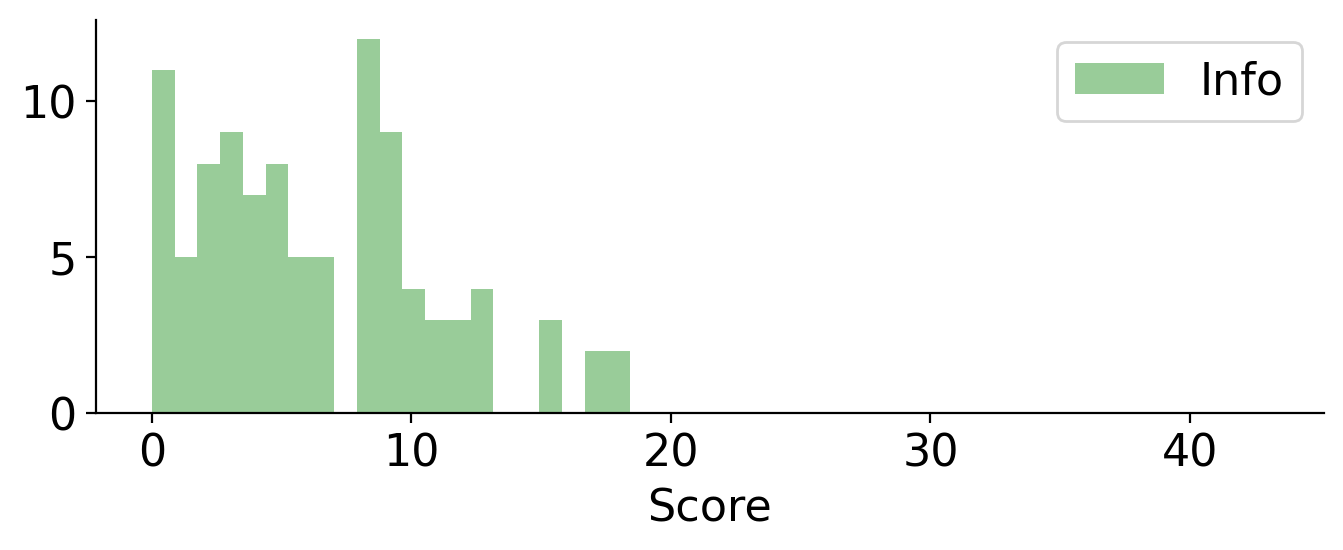

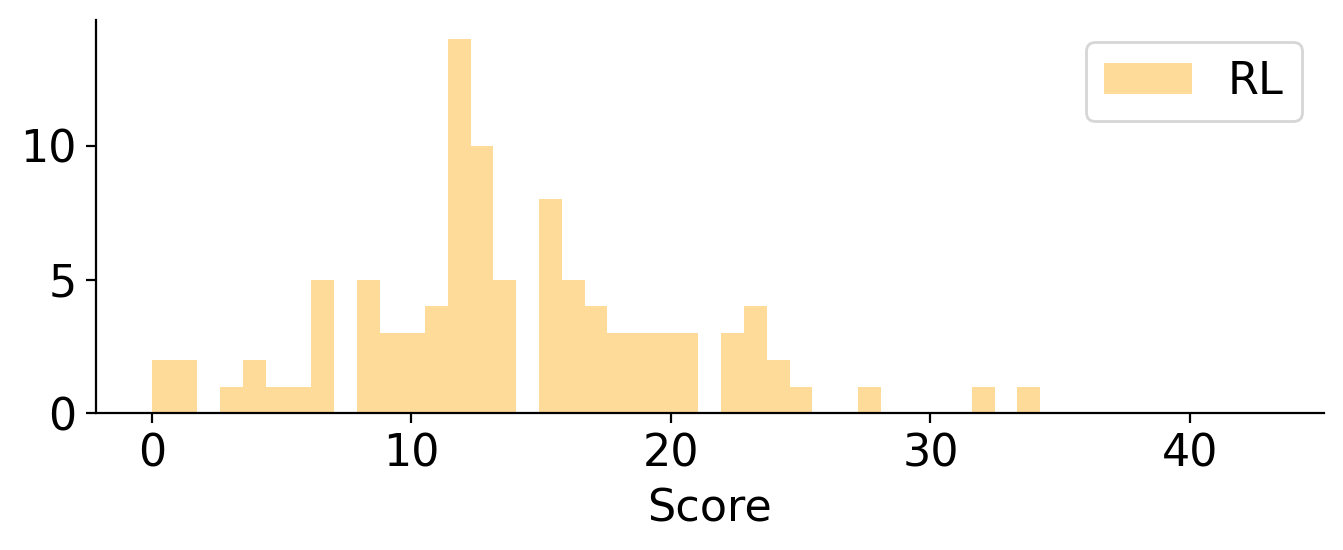

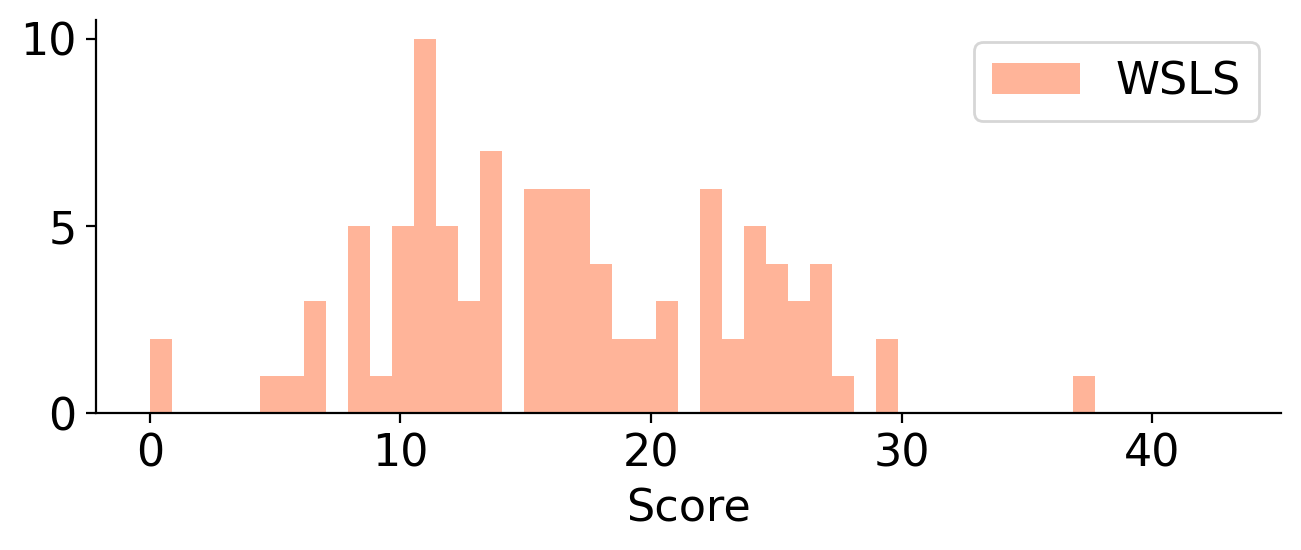

In [ ]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(6, 3))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
# fig = plt.figure(figsize=(7, 5))
for (name, s, c) in zip(names, scores, colors):
    fig = plt.figure(figsize=(7, 3))
    plt.hist(s, label=name, color=c, alpha=0.4, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

---
### Question 2.2


In the same environment, we scaled up th ecomplexity of the decisions of our little bacteria friends. What pattern did you see across agents? Who did the best, who did worse, and who was most variable?

__Answer:__

The chemo agent did the best followed by the accumulator agent with the info agent having the least amount of rewards. The simpler agents performed better because of their simplicity. The other agents are too complex which can overcomplicate things as we just saw above.

---
### Question 2.3

Remember from the prior labs that sometimes the Rando agent outperformed agents with more directed decisions in their search. What changes in the environment would provide an edge for the simpler (and more random) agents?

__Answer:__
Rando agents thrive in envioronments where the rewards are unpredictable/changing and/or enviornments that are noisy because rando agents don't really stick to anything or gather information/store it. They just purely explore through random behavior.
